In [8]:
from matplotlib import pyplot as plt
import pandas as pd
import sys
import joblib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
sys.path.insert(0,"/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
import author
from functools import reduce
engine = author.processed_engine
raw_engine = author.raw_engine
YEAR=365

In [9]:
total_lasso, total_ridge, total_elastic = [joblib.load(f"./{n}") for n in ["Lasso_total.pkl","Ridge_total.pkl","Elastic_total.pkl"]]

In [10]:
def get_df(query, engine):
    df = pd.read_sql(query, engine) #로컬 db에서 테이블 가져옴
    df.set_index(df.columns[0], inplace=True)
    return df

select_all = lambda ticker: f"SELECT * FROM {ticker}_1d"
bit_df = get_df(select_all("BTCUSD"), engine)
qqq_df = get_df(select_all("QQQ"), engine)
tlt_df = get_df(select_all("TLT"), engine)
gld_df = get_df(select_all("GCF"), engine)

bit_fedf = bit_df[["Macd_Signal", "Vwap", "Pct", "Moment", "Fast_d", "Rsi","Price"]]
tlt_fedf = tlt_df[["Moment"]]
qqq_fedf = qqq_df[["Moment"]]
gld_fedf = gld_df[["Moment"]]

vix = get_df("SELECT Date, Close FROM VIX_1d", raw_engine)
usd = get_df("SELECT Date, Close FROM DXF_1d", raw_engine)


data_frames = [bit_fedf, tlt_fedf, qqq_fedf, gld_fedf, vix, usd]
for df, ticker in zip(data_frames, ["BTC","TLT","QQQ","GCF","VIX","USD"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]

df = reduce(lambda left,right: pd.merge(left, right, right_index=True, left_index=True,
                                            how='outer'), data_frames)

df = df.ffill().dropna()
df = df.drop_duplicates()
df


,BTC_Macd_Signal,BTC_Vwap,BTC_Pct,BTC_Moment,BTC_Fast_d,BTC_Rsi,BTC_Price,TLT_Moment,QQQ_Moment,GCF_Moment,VIX_Close,USD_Close
2015-11-11,22.953,270.309,-7.641,1.091,6.247,46.116,311.084,0.979,1.045,0.948,16.059999,99.157997
2015-11-12,20.278,270.823,8.701,1.136,8.413,52.819,338.152,0.981,1.040,0.946,18.370001,98.711998
2015-11-13,17.839,271.171,-0.414,1.130,7.438,52.455,336.753,0.983,1.030,0.946,20.080000,99.097000
2015-11-14,15.418,271.424,-1.142,1.122,5.462,51.409,332.906,0.983,1.030,0.946,20.080000,99.097000
2015-11-15,12.330,271.667,-3.827,1.097,4.100,47.993,320.166,0.983,1.030,0.946,20.080000,99.097000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,-943.277,27887.285,5.160,61.846,17.622,48.366,39698.371,1.028,2.231,1.302,25.420000,102.594002
2022-05-05,-1073.475,27897.073,-7.867,61.371,16.616,38.143,36575.141,1.015,2.205,1.304,31.200001,103.802002
2022-05-06,-1205.865,27904.415,-1.461,60.949,14.637,36.714,36040.922,1.008,2.196,1.307,30.190001,103.680000
2022-05-07,-1338.842,27908.839,-1.495,60.490,12.998,35.278,35501.953,1.008,2.196,1.307,30.190001,103.680000


In [11]:
X = df.drop(['BTC_Price'], axis=1).iloc[:-1]
y = df['BTC_Price'].iloc[1:]

In [12]:
up_ratio = (X['BTC_Pct'] > 0).sum() / X.shape[0] #오른 날의 비율
down_ratio = 1 - up_ratio
print(f"up: {up_ratio}, down: {down_ratio}")

up: 0.5447257383966245, down: 0.4552742616033755


In [13]:
X

,BTC_Macd_Signal,BTC_Vwap,BTC_Pct,BTC_Moment,BTC_Fast_d,BTC_Rsi,TLT_Moment,QQQ_Moment,GCF_Moment,VIX_Close,USD_Close
2015-11-11,22.953,270.309,-7.641,1.091,6.247,46.116,0.979,1.045,0.948,16.059999,99.157997
2015-11-12,20.278,270.823,8.701,1.136,8.413,52.819,0.981,1.040,0.946,18.370001,98.711998
2015-11-13,17.839,271.171,-0.414,1.130,7.438,52.455,0.983,1.030,0.946,20.080000,99.097000
2015-11-14,15.418,271.424,-1.142,1.122,5.462,51.409,0.983,1.030,0.946,20.080000,99.097000
2015-11-15,12.330,271.667,-3.827,1.097,4.100,47.993,0.983,1.030,0.946,20.080000,99.097000
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-03,-1081.377,27877.427,-2.022,61.989,7.911,38.879,1.026,2.217,1.302,29.250000,103.496002
2022-05-04,-943.277,27887.285,5.160,61.846,17.622,48.366,1.028,2.231,1.302,25.420000,102.594002
2022-05-05,-1073.475,27897.073,-7.867,61.371,16.616,38.143,1.015,2.205,1.304,31.200001,103.802002
2022-05-06,-1205.865,27904.415,-1.461,60.949,14.637,36.714,1.008,2.196,1.307,30.190001,103.680000


In [14]:
model_predict = pd.Series(total_ridge.predict(X), index=y.index)
# ridge_only_predict = pd.Series(btc_ridge.predict
# (X), index=y.index)
# total_only_predict = (lasso_only_predict + ridge_only_predict)/2

비트코인 데이터로만 학습한 모델을 최적화 하자

In [15]:
def plot_bar(data, name):
    cnts = data.value_counts()
    cnts.sort_values(ascending=False,inplace=True)
    plt.figure(figsize=(12,8))
    plt.bar(cnts.index, cnts.values)
    plt.ylabel("Count")
    plt.xlabel("Error %")
    plt.xticks(range(-100,100,10))
    plt.title(name)
    plt.xlim(-100,100)

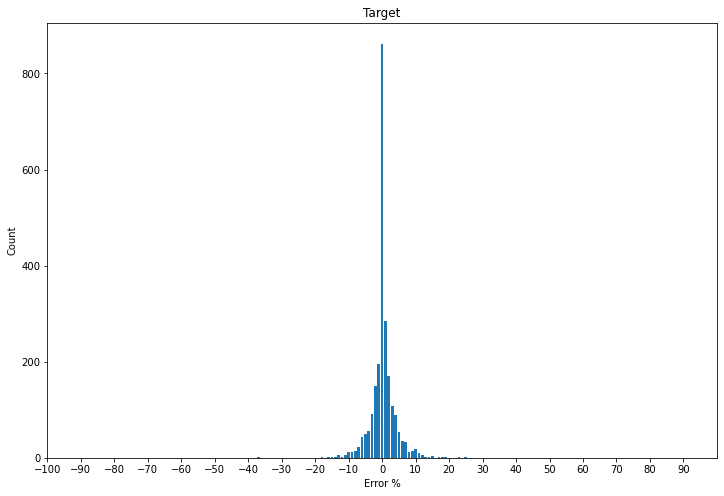

In [16]:
plot_bar(df['BTC_Pct'].astype(int), name="Target")

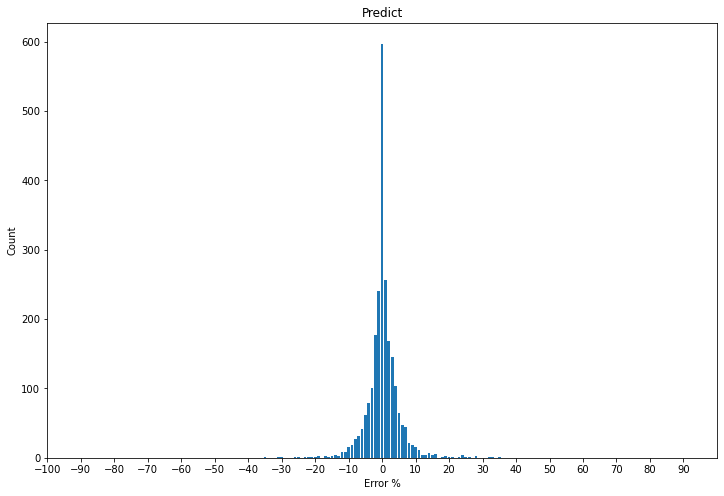

In [17]:
pred_pct = model_predict.pct_change().dropna() * 100
plot_bar(pred_pct.astype(int), name="Predict")

var: 65.3503442180291, mean: 0.5100938135650596


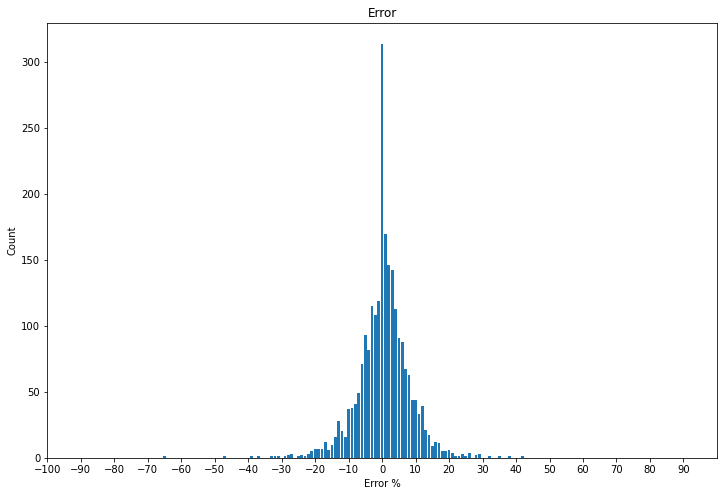

In [18]:
error = (y - model_predict) * 100 / y
error_mean = error.mean()
error_var = error.var()
error = error.astype(int)
print(f"var: {error_var}, mean: {error_mean}")
plot_bar(error,name="Error")


In [19]:
def get_thershold(pred_pct, X):
    for t in range(-5,5):
        pred_pct = pred_pct.round(2)
        price_pct = df['BTC_Pct'].iloc[1:] #y와 인덱스를 맞춰준다.
        true_pos = pred_pct[(pred_pct > t) & (price_pct > 0)] #모델이 상승세라 예측했고 실제로 상승한 날들
        false_pos = pred_pct[(pred_pct > t) & (price_pct <= 0)]
        true_neg = pred_pct[(pred_pct < t) & (price_pct < 0)]
        false_neg = pred_pct[(pred_pct < t) & (price_pct >= 0)]
        print("Threshold: ", t)
        print(f"true_pos: {len(true_pos)}, false_pos: {len(false_pos)}")
        print(f"true_neg: {len(true_neg)}, false_neg: {len(false_neg)}")
        precison = len(true_pos) / (len(true_pos) + len(false_pos))
        recall = len(true_pos) / (len(true_pos) + len(false_neg))
        f1 = (2 * precison * recall) / (precison + recall)
        print("Precision: ",precison)
        print("Recall: ",recall)
        print("F1: ", f1)

now_price = df['BTC_Price'].iloc[:-1]
pred_profit = 100 * (model_predict.values - now_price.values) / now_price
get_thershold(pred_profit, X)
# get_thershold(pred_pct, X)
    

Threshold:  -5
true_pos: 912, false_pos: 1005
true_neg: 72, false_neg: 380
Precision:  0.4757433489827856
Recall:  0.7058823529411765
F1:  0.5684013711436585
Threshold:  -4
true_pos: 806, false_pos: 981
true_neg: 96, false_neg: 486
Precision:  0.451035254616676
Recall:  0.6238390092879257
F1:  0.5235466060409224
Threshold:  -3
true_pos: 705, false_pos: 950
true_neg: 127, false_neg: 585
Precision:  0.4259818731117825
Recall:  0.5465116279069767
F1:  0.4787775891341256
Threshold:  -2
true_pos: 575, false_pos: 910
true_neg: 167, false_neg: 714
Precision:  0.3872053872053872
Recall:  0.44608223429014743
F1:  0.414563806777217
Threshold:  -1
true_pos: 453, false_pos: 829
true_neg: 246, false_neg: 840
Precision:  0.3533541341653666
Recall:  0.3503480278422274
F1:  0.3518446601941747
Threshold:  0
true_pos: 342, false_pos: 726
true_neg: 350, false_neg: 948
Precision:  0.3202247191011236
Recall:  0.2651162790697674
F1:  0.2900763358778626
Threshold:  1
true_pos: 254, false_pos: 647
true_neg: 4

In [21]:
def get_profit_pct(pred_pct, thereshold): 
    """ 예측 데이터와 실제 가격의 증감률의 차이에 따라 투자 조건을 다르게 했을 때의
        달라지는 수익률 곡선을 구해준다.
    """
    buy_point = [] #예측 값이 %이상일 때 매수한다.
    sell_point = [] #손익을 실현 시키기 이전 거래일
    for i in pred_pct[pred_pct.values > thereshold].index:
        try:
            index = y.index.get_loc(i) + 1        #매수 다음 거래일에 바로 매도한다.
            if index < len(y):
                sell_point.append(index)
                buy_point.append(index - 1)
        except: 
            continue
            
    buy_value = y.iloc[buy_point]
    sell_value = y.iloc[sell_point]
    profit_pct = (sell_value.values - buy_value.values) / buy_value.values
    return pd.Series(index=sell_value.index, data=profit_pct)

def get_profit(profit_pct, days=0):
    seed = 1 #처음 seed
    seed_record = []
    for p in profit_pct[-days:]:
        seed = seed * (1 + p)  #profit 저장용
        seed_record.append(seed)
    return seed_record

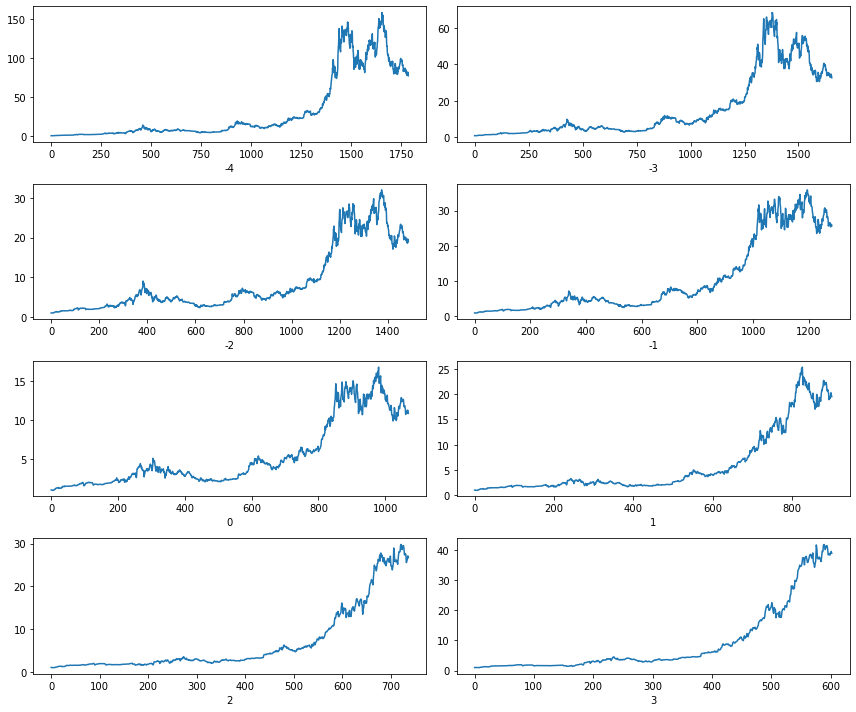

In [22]:
n_split = 8
start = -4
end = start + n_split
rows = lambda x: x//2 if x % 2 == 0 else x//2 + 1
fig, axes = plt.subplots(rows(n_split), 2, figsize=(12,10))
results = {}
for i, v in enumerate(range(start, end), start=1):
    profit_pct = get_profit_pct(pred_profit, v)
    results[v] = pd.Series(index=profit_pct.index ,data=profit_pct)
    plt.subplot(rows(n_split), 2, i)
    plt.plot(get_profit(results[v]))
    plt.xlabel(v)
plt.tight_layout()

(18621.0, 19120.0)

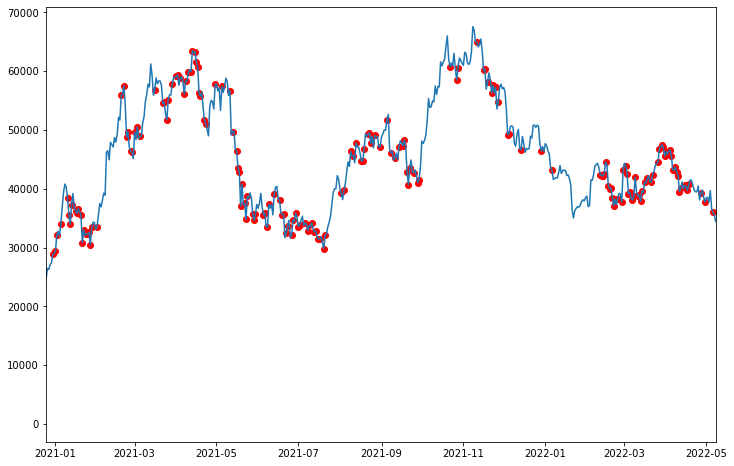

In [26]:
sell_point = results[1].index
sell_value = y.loc[sell_point]
plt.figure(figsize=(12,8))
plt.plot(y)
plt.scatter(x=sell_point, y = sell_value, c='r')
plt.xlim(df.index[-500],df.index[-1])


In [48]:
for r in results:
    print(f"{r}: {len(results[r])}")
    print()

-4: 1801

-3: 1666

-2: 1517

-1: 1367

0: 1185

1: 983

2: 811

3: 683



In [66]:
momentum = {}
FIRST = 5
SECOND = 10
THIRD = 30
for k in results.keys():
    profit = results[k] * 100
    short = profit.rolling(FIRST).apply(lambda x: x.prod() ** (1.0 / FIRST))
    # mid = profit / profit.rolling(SECOND).mean() #1달 간의 기하 평균 수익률
    # long = profit / profit.rolling(THIRD).mean() #2달 간의 기하 평균 수익률
    # # apply(lambda x: x.prod() ** (1.0 / SECOND))
    # momentum[k] = (short * 0.5 + mid * 0.3 + long * 0.2)
    momentum[k] = short

In [67]:
moment_df = pd.DataFrame(momentum)
moment_df = moment_df.ffill()
moment_df = moment_df.fillna(0)
moment_df

,-4,-3,-2,-1,0,1,2,3
time,,,,,,,,
2015-03-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2022-05-04,1.499091,1.499091,1.499091,1.499091,1.144917,1.423248,1.423248,2.498491
2022-05-05,1.914142,1.914142,1.914142,1.914142,1.465527,1.423248,1.423248,2.498491
2022-05-06,1.914142,1.914142,1.914142,1.914142,1.465527,1.423248,1.423248,2.498491


In [68]:
moment_df.max()

-4     8.366104
-3     8.366104
-2     8.366104
-1     7.767270
 0     9.458993
 1    10.908760
 2     8.194474
 3     7.465864
dtype: float64

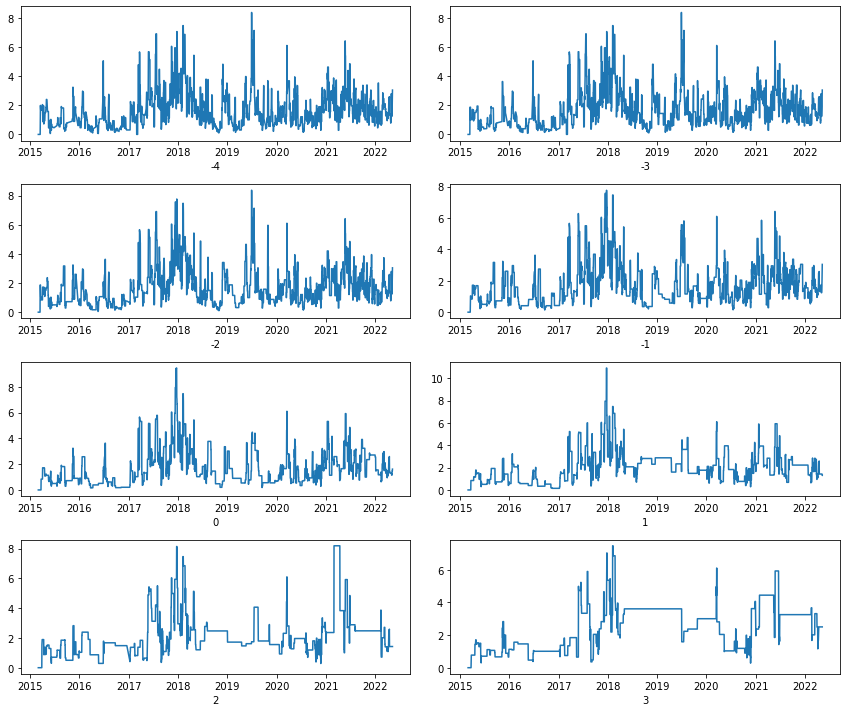

In [69]:
fig, axes = plt.subplots(rows(n_split), 2, figsize=(12,10))
for i, v in enumerate(range(start, end), start=1):
    plt.subplot(rows(n_split), 2, i)
    plt.plot(moment_df[v])
    plt.xlabel(v)
plt.tight_layout()

In [71]:
thers_df = moment_df.idxmax(axis=1)
thers_df

time
2015-03-02   -4
2015-03-03   -4
2015-03-08   -4
2015-03-10   -4
2015-03-15   -4
             ..
2022-05-04    3
2022-05-05    3
2022-05-06    3
2022-05-07   -4
2022-05-08   -4
Length: 2283, dtype: int64

In [74]:
profit_df = pd.DataFrame([thers_df,pred_profit]).T
profit_df.columns =["threshold","profit_pct"]
profit_df.dropna(inplace=True)
profit_df

,threshold,profit_pct
time,,
2015-03-02,-4.0,0.564319
2015-03-03,-4.0,-11.786686
2015-03-08,-4.0,-6.386556
2015-03-10,-4.0,-13.275859
2015-03-15,-4.0,1.928742
...,...,...
2022-05-03,3.0,-0.092013
2022-05-04,3.0,0.946194
2022-05-05,3.0,-0.073320


In [80]:
profit_df[profit_df['threshold'] < profit_df['profit_pct']]

,threshold,profit_pct
time,,
2015-03-02,-4.0,0.564319
2015-03-15,-4.0,1.928742
2015-03-16,-3.0,-2.055393
2015-03-20,-3.0,8.118335
2015-03-21,-4.0,5.650945
...,...,...
2022-04-14,-4.0,2.454011
2022-04-15,-4.0,2.007789
2022-04-29,-4.0,-0.348684


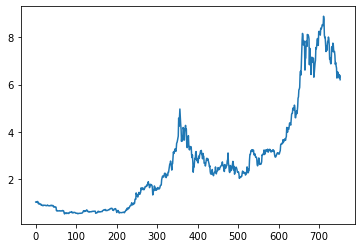

In [82]:
buy_point = [] #예측 값이 %이상일 때 매수한다.
sell_point = [] #손익을 실현 시키기 이전 거래일
for i in profit_df[profit_df['threshold'] < profit_df['profit_pct']].index:
    try:
        index = y.index.get_loc(i) + 1        #매수 다음 거래일에 바로 매도한다.
        if index < len(y):
            sell_point.append(index)
            buy_point.append(index - 1)
    except: 
        continue
            
buy_value = y.iloc[buy_point]
sell_value = y.iloc[sell_point]
profit_pct = (sell_value.values - buy_value.values) / buy_value.values
plt.plot(get_profit(pd.Series(index=sell_value.index, data=profit_pct)))
